In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Dense,Embedding, Input , Activation
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, optimizers, layers
from sklearn.metrics import  roc_auc_score

import warnings
warnings.simplefilter(action="ignore")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [6]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[classes].values

train_sentences = train['comment_text']
test_sentences = test['comment_text']
print(targets)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


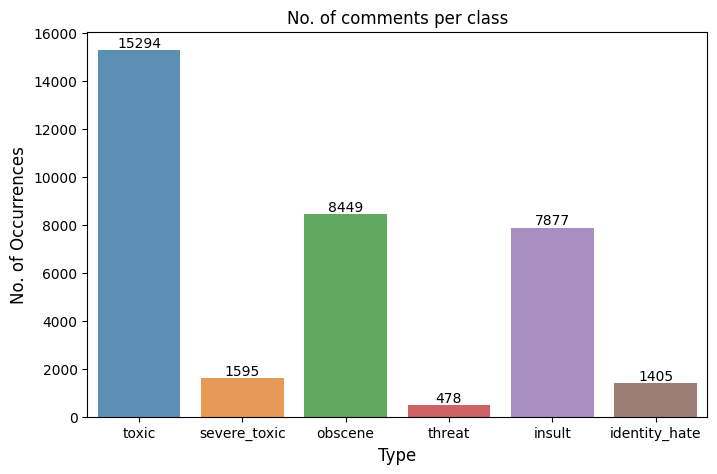

In [8]:
value_counts = train[classes].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=value_counts.index, y=value_counts.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type', fontsize=12)

rects = ax.patches
labels = value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

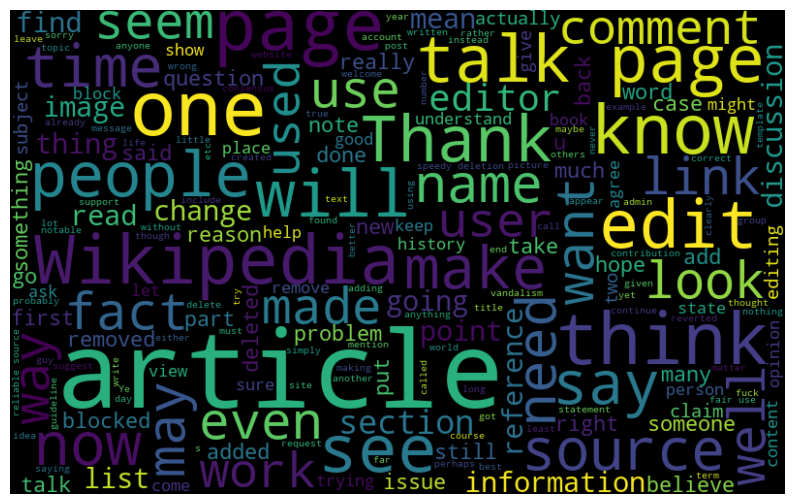

In [9]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in train['comment_text'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [7]:
max_features = 22000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train_sentences))

tokenized_train = tokenizer.texts_to_sequences(train_sentences)
tokenized_test = tokenizer.texts_to_sequences(test_sentences)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
maxlen = 200
X_train = pad_sequences(tokenized_train, maxlen = maxlen)
X_test = pad_sequences(tokenized_test, maxlen = maxlen)

In [13]:
embed_size = 128
maxlen = 200
max_features = 22000

inp = Input(shape = (maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [14]:
model = Model(inputs=inp, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2816000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d (Glob  (None, 60)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [16]:
batch_size = 64
epochs = 2
model.fit(X_train, targets, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
2244/2244 [==============================] - 585s 258ms/step - loss: 0.0810 - accuracy: 0.9397 - val_loss: 0.0516 - val_accuracy: 0.9940
Epoch 2/2
2244/2244 [==============================] - 575s 256ms/step - loss: 0.0470 - accuracy: 0.9917 - val_loss: 0.0498 - val_accuracy: 0.9936


In [18]:
prediction = model.predict(X_test)
prediction

4787/4787 [==============================] - 249s 52ms/step


array([[9.9509507e-01, 2.7322504e-01, 9.3900156e-01, 4.3618437e-02,
        8.4469914e-01, 1.9020936e-01],
       [1.3530300e-03, 9.8095086e-07, 2.3017994e-04, 3.0646705e-05,
        1.4704737e-04, 3.4525299e-05],
       [2.0303791e-03, 1.9661040e-06, 3.2654690e-04, 6.1755993e-05,
        2.2950496e-04, 6.2792358e-05],
       ...,
       [3.1796561e-04, 6.1261382e-08, 7.0906870e-05, 2.0401997e-06,
        3.0521376e-05, 4.3274422e-06],
       [1.0006126e-03, 4.7013756e-07, 2.2084081e-04, 9.4249681e-06,
        1.1742000e-04, 2.0404706e-05],
       [9.4954163e-01, 2.1268614e-02, 7.2774142e-01, 1.0680992e-02,
        4.5496246e-01, 4.6752311e-02]], dtype=float32)